## Mice HRV Analysis

## Protocol (Thireau)

### Selection criteria of sinus heart beats:
- Removing R-R values not contained between mean R-R interval +- 2 S.D
- This can discard arrythmias, ectopic beats, and artifacs

### Time domain analysis:
- pNN, p = 6
- 12 hour analysis for each mouse (onset and offset)
- Mouse 4 & Mouse 5

### Frequency domain analysis
- analysing 3 min ECG periode every 120 minutes
- averaging onset and offset data
- Mouse 4 and Mouse 5

### Load necessary packages

In [10]:
import numpy as np
import pyhrv.tools as tools
import mat73
from datetime import datetime, timedelta

In [11]:
import wfdb
from wfdb import processing
import matplotlib.pyplot as plt
import numpy as np
from pyhrv import hrv

In [12]:
import pyhrv.time_domain as td 

### Class data

In [13]:
import logging as log

class AdInstrumentData:
    
    def __init__(self, mat_files):
        # matfiles: can load several mat files
        
        data_dict = mat73.loadmat(mat_files[0])
        # extract start time
        data_starts = data_dict['record_meta']['data_start']
        self.__start_time = self.__days2datetime(data_starts[0]) if isinstance(data_starts, list) else self.__days2datetime(data_starts)
        
        # extract data frequency
        tick_dts = data_dict['record_meta']['tick_dt']
        self.__fs = 1/tick_dts[0] if isinstance(tick_dts, list) else 1/tick_dts

        from operator import itemgetter
        self.__template = 'data__chan_'
        all_ticks = {}
        
        def extract_ticks(data, all_ticks):
            # combine all ticks
            
            tmp_keys = []
            for key in data.keys():
                if self.__template in key:
                    tmp_keys += [[int(k) for k in key.split('_') if k.isnumeric()] + [key]]
            tmp_keys = sorted(tmp_keys, key=itemgetter(0, 1))

            for l_key in tmp_keys:
                key = self.__template + str(l_key[0])
                if type(data[l_key[-1]]) == np.ndarray:
                    all_ticks[key] = np.concatenate((all_ticks[key], data[l_key[-1]])) if key in all_ticks else data[l_key[-1]]

        extract_ticks(data_dict, all_ticks)
        for file in mat_files[1:]:
            extract_ticks(mat73.loadmat(file), all_ticks)
        self.__all_ticks = all_ticks
        self.__stop_time = self.__start_time + timedelta(seconds=len(self.all_ticks[self.__template+'1'])/self.__fs)
        
        drl data_dict
        log.info(f'Labchart data from {str(self.__start_time)} to {str(self.__stop_time)}')
        
    
    def __days2datetime(self, days):
        # days, ex: array(739071.96513903)
        reference_date = datetime(1, 1, 1)
        return reference_date + timedelta(days=float(days)-367)
    
    @property
    def start_time(self):
        return self.__start_time
    
    @property
    def fs(self):
        return self.__fs
    
    @property
    def all_ticks(self):
        return self.__all_ticks
    
    @property
    def channels(self):
        return [c[len(self.__template):] for c in self.__all_ticks.keys()]
        
    def __get_ecg_range(self, from_time, channel, duration=180):
        """
        from_time : time to extract, format: yyyy-mm-dd hh:m:ss.f
        duration : duration in seconds, default = 3 minutes = 3 * 60 seconds
        channel : start from 1
        return: validity(%), ticks
        """
        
        date_format = "%Y-%m-%d %H:%M:%S.%f"
        ga_from = datetime.strptime(from_time, date_format)
        ga_to = ga_from + timedelta(seconds=duration)
        if ga_from >= self.__start_time and ga_from <= ga_to:
            tick_from = round((ga_from - self.__start_time).total_seconds() * self.__fs)
            tick_to = round((ga_to - self.__start_time).total_seconds() * self.__fs)
            tick_channel = self.__template + str(channel)
            ticks = self.__all_ticks[tick_channel][tick_from:tick_to]
            validity_channel = self.__template + str(channel + 1 if (channel + 1) % 3 == 0 else channel + 2)
            validity = self.__all_ticks[validity_channel][tick_from:tick_to]
            # calculate validity level
            val_level = np.mean(validity)
            # remove ticks with invalid recording
            condition = validity < 0.5
            filtered_ticks = ticks[~condition]
            
            return val_level, filtered_ticks
    
    
    def get_data(self, from_time, channel, duration=180):
        val_level, signal = self.__get_ecg_range(from_time, channel, duration)
        
        # GET PEAKS
        # rqrs config file for mouse
        # using PhysioZoo setup
        hr = 608
        qs = 0.00718
        qt = 0.03
        QRSa = 1090
        QRSamin = 370
        rr_min = 0.05
        rr_max = 0.24
        window_size_sec = 0.005744 # 0.8*QS

        # adjusting peaks location
        peaks_window = 17
        th = 0.5
        # Use the maximum possible bpm as the search radius
        # Ostergaard G, Hansen HN, Ottesen JL. Physiological, Hematological, and Clinical Chemistry Parameters, Including Conversion Factors. In: Hau J, Schapiro SJ, editors. Handbook of laboratory animal science, Volume I: Essential Principles and Practices. 3rd ed. Vol. 1. Boca Raton, FL: CRC Press; 2010. pp. 667–707.
        min_bpm = 310
        max_bpm = 840
        search_radius = int(self.__fs * 60 / max_bpm)

        # Use the GQRS algorithm to detect QRS locations in the first channel
        qrs_inds = processing.qrs.gqrs_detect(sig=signal, 
                                              fs=self.__fs, 
                                              RRmin=rr_min, 
                                              RRmax=rr_max,
                                              hr=hr, 
        #                                       QS=qs, 
                                              QT=qt, 
                                              QRSa=QRSa, 
        #                                       QRSamin=QRSamin
                                             )
        
        # Correct the peaks shifting them to local maxima
        peaks = processing.peaks.correct_peaks(
            signal,
            peak_inds=qrs_inds,
            search_radius=search_radius, 
            smooth_window_size=peaks_window
        )
    
        # GET NNI, THEN FILTER NNI and PEAKS
        nni = peaks[1:] - peaks[:-1]
        condition = (nni >= rr_min*self.__fs) & (nni <= rr_max*self.__fs)
        nni = nni[condition]
        # peaks = peaks[np.insert(condition, 0, True)]
        
        # filter nni within mean +- std2x
        nni_mean = np.mean(nni)
        std2x = 2 * np.std(nni)
        condition = (nni >= nni_mean-std2x) & (nni <= nni_mean+std2x)
        nni = nni[condition]
        # peaks = peaks[np.insert(condition, 0, True)]
        return {"val_level": val_level, "signal": signal, "nni": nni, "peaks": peaks}
    
    def time_domain_analysis(self, channel, from_time, duration=5, threshold=6, plot=False):
        data = self.get_data(from_time, channel, duration)
        results = td.time_domain(data['nni'], threshold=threshold, plot=plot)
        rs = dict(results)
        rs['val_level'] = data['val_level']
        rs['channel'] = channel
        rs['from_time'] = from_time
        return rs
    
    def frequency_domain_analysis(self, from_time, channel, duration=3, repeat=120, threshold=6):
        """
        from_time : time to extract, format: yyyy-mm-dd hh:m:ss.f
        duration : duration in minutes, default=5 minutes
        channel : start from 1
        return: validity(%), ticks
        """
        pass
    

In [14]:
data_path = 'data'

INFO:root:Labchart data from 2023-07-02 22:17:14.762771 to 2023-07-03 10:17:14.762771


dict_keys(['val_level', 'signal', 'nni', 'peaks'])


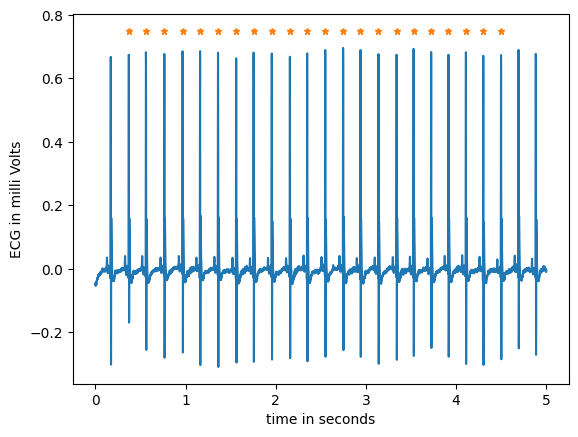

In [15]:
# import electrocardiogram
import matplotlib.pyplot as plt
  
# import numpy
import numpy as np
  
data = AdInstrumentData([f'./{data_path}/Mouse03 to 06_20230702 pm.mat'])
results = data.get_data("2023-07-03 02:00:00.0", 5, 5)

# calculating time data with ecg size along with frequency
time_data = np.arange(results['signal'].size) / data.fs
print(results.keys())
# plotting time and ecg model
plt.plot(time_data, results['signal'])
plt.xlabel("time in seconds")
plt.ylabel("ECG in milli Volts")

plt.plot(results['peaks']/data.fs, [0.75]*len(results['peaks']) , marker='*', ls='none', ms=5)
  
# display
plt.show()

## Analysis mouse 4 (channel 5)

### Loading recipe file
hrv_recipe.csv contains files, categories, onset/offset, channel, duration, and name for analysis

In [16]:
log.getLogger().setLevel(log.INFO)
results = {'before_GA': {'onset': [], 'offset':[]}, 'after_GA':{'onset': [], 'offset':[]}}

### CSV contains files, onset, offset, before GA, after GA, and during GA for mouse 3 and mouse 4

In [21]:
import pandas as pd

recipe_df = pd.read_csv('hrv_recipe.csv')
recipe_df

,category,name,files,set,channel,time,duration,threshold,Unnamed: 8,Unnamed: 9,...,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,before_GA,GA-2023-07-05,"['Mouse03 to 06_20230702 pm.mat', 'Mouse03 to ...",onset,5,2023-07-03 08:40:00.0,43200,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,before_GA,GA-2023-07-05,"['Mouse03 to 06_20230702 pm.mat', 'Mouse03 to ...",offset,5,2023-07-04 20:40:00.0,43200,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,before_GA,GA-2023-06-07,"['Mouse03 to 06_20230605 pm.mat', 'Mouse03 to ...",onset,5,2023-06-06 11:30:00.0,43200,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,before_GA,GA-2023-06-07,"['Mouse03 to 06_20230605 pm.mat', 'Mouse03 to ...",onset,8,2023-06-06 12:30:00.0,43200,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,before_GA,GA-2023-06-07,"['Mouse03 to 06_20230605 pm.mat', 'Mouse03 to ...",offset,5,2023-06-05 23:30:00.0,43200,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,before_GA,GA-2023-06-07,"['Mouse03 to 06_20230605 pm.mat', 'Mouse03 to ...",offset,8,2023-06-06 00:30:00.0,43200,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,before_GA,GA-2023-05-23,"['Mouse03 to 06_20230521 pm.mat', 'Mouse03 to ...",onset,5,2023-05-22 13:00:00.0,43200,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,before_GA,GA-2023-05-23,"['Mouse03 to 06_20230521 pm.mat', 'Mouse03 to ...",onset,8,2023-05-22 14:30:00.0,43200,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,before_GA,GA-2023-05-23,"['Mouse03 to 06_20230521 pm.mat', 'Mouse03 to ...",offset,5,2023-05-22 01:00:00.0,43200,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,before_GA,GA-2023-05-23,"['Mouse03 to 06_20230521 pm.mat', 'Mouse03 to ...",offset,8,2023-05-22 02:30:00.0,43200,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculating statitical data for all condition (before_GA and after_GA, onset and offset)

#### RELAX, this will take couple of hours

In [23]:
import ast
### Loop to get before_GA results

mats = None
prev_files = ()
for index, row in recipe_df.sort_values(by=['files']).iterrows():
    files = tuple([f'./{data_path}/{file}' for file in ast.literal_eval(row['files'])])
    if files != prev_files:
        mats = AdInstrumentData(files)
        prev_files = files
    results[row['category']][row['set']] += [mats.time_domain_analysis(row['channel'], row['time'], row['duration'], row['threshold'])]

INFO:root:Labchart data from 2023-05-07 21:08:41.295603 to 2023-05-09 09:08:41.295603
/Users/ymun794/Documents/Mouse/venv/lib/python3.10/site-packages/pyhrv/time_domain.py:576: UserWarning: CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a malfunction of the function. This function will be reviewed over the next updates to solve this issue
  warnings.warn('CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a '


In [ ]:
np.save('results-'+str(datetime.now()), results)

### Before GA analysis

#### Onset

In [ ]:
df = pd.DataFrame(results['before_GA']['onset'])

projected = ['nni_mean', 'nni_min', 'nni_max', 'hr_mean', 'hr_min', 'hr_max', 'hr_std', 'sdnn', 'sdann', 'rmssd', 'pnn6', 'channel']
df[projected]

,nni_counter,nni_mean,nni_min,nni_max,hr_mean,hr_min,hr_max,hr_std,nni_diff_mean,nni_diff_min,...,nn6,pnn6,nni_histogram,tinn_n,tinn_m,tinn,tri_index,val_level,channel,from_time
0,205387,147.854071,86.0,216.0,420.641389,277.777778,697.674419,79.002217,8.976853,0,...,57048,27.775993,None,0,0,0,8.126414,0.819100,5,2023-07-03 08:40:00.0
1,204142,151.209521,89.0,219.0,411.500905,273.972603,674.157303,78.136427,8.772020,0,...,60927,29.845548,None,0,0,0,8.564800,0.825873,5,2023-06-06 11:30:00.0
2,117263,154.497079,91.0,221.0,403.726046,271.493213,659.340659,79.963439,11.093005,0,...,39772,33.917211,None,0,0,0,10.227019,0.497338,8,2023-06-06 12:30:00.0
3,204042,157.940620,98.0,222.0,392.265269,270.270270,612.244898,70.563960,7.073010,0,...,61474,30.128259,None,0,0,0,8.787339,0.881041,5,2023-05-22 13:00:00.0
4,244763,152.727071,94.0,217.0,406.306859,276.497696,638.297872,74.349349,8.092249,0,...,83400,34.073917,None,0,0,0,9.264658,0.984627,8,2023-05-22 14:30:00.0


In [ ]:
np.mean(df['nni_mean']), np.std(df['nni_mean'])

In [ ]:
np.mean(df['sdnn']), np.std(df['sdnn'])

#### Offset

In [ ]:
df = pd.DataFrame(results['after_GA']['offset'])
df[projected]

,nni_mean,nni_min,nni_max,hr_mean,hr_min,hr_max,hr_std,sdnn,sdann,rmssd,pnn6,channel
0,175.018113,120.0,229.0,350.217950,262.008734,500.000000,52.738938,24.871629,18.658119,9.151018,33.145535,5
1,155.001215,98.0,213.0,399.772348,281.690141,612.244898,73.559734,27.224779,22.492639,15.085609,17.567384,5
2,159.215958,105.0,212.0,387.229565,283.018868,571.428571,66.532486,25.209847,20.105746,9.608303,17.723563,8
3,173.522170,115.0,231.0,354.478983,259.740260,521.739130,56.884736,26.946467,21.203496,10.124682,32.313285,5
4,174.227913,113.0,234.0,354.885593,256.410256,530.973451,64.167894,29.002163,23.322801,10.439872,30.426904,8
5,168.480768,108.0,230.0,367.278703,260.869565,555.555556,65.917975,29.020463,23.359087,10.502569,26.997005,5
6,168.537588,111.0,226.0,366.348136,265.486726,540.540541,64.305941,27.557093,21.632176,11.154987,31.931187,8


In [ ]:
np.mean(df['nni_mean']), np.std(df['nni_mean'])

In [ ]:
np.mean(df['sdnn']), np.std(df['sdnn'])

### After GA analysis

#### Onset

In [ ]:
df = pd.DataFrame(results['after_GA']['onset'])
df[projected]

,nni_counter,nni_mean,nni_min,nni_max,hr_mean,hr_min,hr_max,hr_std,nni_diff_mean,nni_diff_min,...,nn6,pnn6,nni_histogram,tinn_n,tinn_m,tinn,tri_index,val_level,channel,from_time
0,257370,150.935358,102.0,202.0,406.560999,297.029703,588.235294,62.546517,5.592733,0,...,69325,26.936033,None,0,0,0,7.350698,0.983537,5,2023-07-06 08:20:00.0
1,224280,152.477394,99.0,211.0,404.133145,284.360190,606.060606,66.326956,6.076400,0,...,55116,24.574748,None,0,0,0,7.659574,0.885828,5,2023-06-08 12:30:00.0
2,211320,149.888416,92.0,212.0,413.261658,283.018868,652.173913,72.980593,5.976202,0,...,43385,20.530572,None,0,0,0,7.382100,0.803235,8,2023-06-08 12:00:00.1
3,189197,150.631257,93.0,215.0,410.787460,279.069767,645.161290,71.304054,7.595922,0,...,55121,29.134337,None,0,0,0,6.650859,0.767753,5,2023-05-24 13:00:00.0
4,241958,145.972867,81.0,216.0,428.381975,277.777778,740.740741,85.395925,9.400588,0,...,78943,32.626872,None,0,0,0,8.257389,0.924579,8,2023-05-24 13:30:00.0
5,237503,153.171817,96.0,216.0,403.521465,277.777778,625.000000,68.831402,6.601069,0,...,61291,25.806520,None,0,0,0,7.339400,0.959635,5,2023-05-10 15:00:00.0
6,247775,147.675984,91.0,210.0,418.527382,285.714286,659.340659,71.509777,7.970889,0,...,81129,32.743145,None,0,0,0,7.398035,0.970315,8,2023-05-10 16:30:00.0


In [ ]:
np.mean(df['nni_mean']), np.std(df['nni_mean'])

In [ ]:
np.mean(df['sdnn']), np.std(df['sdnn'])

#### Offset

In [ ]:
df = pd.DataFrame(results['after_GA']['offset'])
df[projected]

,nni_mean,nni_min,nni_max,hr_mean,hr_min,hr_max,hr_std,sdnn,sdann,rmssd,pnn6,channel
0,175.018113,120.0,229.0,350.217950,262.008734,500.000000,52.738938,24.871629,18.658119,9.151018,33.145535,5
1,155.001215,98.0,213.0,399.772348,281.690141,612.244898,73.559734,27.224779,22.492639,15.085609,17.567384,5
2,159.215958,105.0,212.0,387.229565,283.018868,571.428571,66.532486,25.209847,20.105746,9.608303,17.723563,8
3,173.522170,115.0,231.0,354.478983,259.740260,521.739130,56.884736,26.946467,21.203496,10.124682,32.313285,5
4,174.227913,113.0,234.0,354.885593,256.410256,530.973451,64.167894,29.002163,23.322801,10.439872,30.426904,8
5,168.480768,108.0,230.0,367.278703,260.869565,555.555556,65.917975,29.020463,23.359087,10.502569,26.997005,5
6,168.537588,111.0,226.0,366.348136,265.486726,540.540541,64.305941,27.557093,21.632176,11.154987,31.931187,8


In [ ]:
np.mean(df['nni_mean']), np.std(df['nni_mean'])

In [ ]:
np.mean(df['sdnn']), np.std(df['sdnn'])

### Loading data during GA

In [ ]:
file = [f'./{data_path}/Mouse03 to 06_20230705 am.mat']
data_during = AdInstrumentData(file)

INFO:root:Labchart data from 2023-07-05 11:09:58.590943 to 2023-07-05 23:09:58.590943


In [ ]:
start_GA = "2023-07-05 16:00:00.0"
duration = 5 * 60 * 60
channel = 5
threshold = 6

{'nni_counter': 127287,
 'nni_mean': 134.32067689551957,
 'nni_min': 102.0,
 'nni_max': 170.0,
 'hr_mean': 451.25152077530055,
 'hr_min': 352.94117647058823,
 'hr_max': 588.2352941176471,
 'hr_std': 46.880456746854115,
 'nni_diff_mean': 1.1465754285624499,
 'nni_diff_min': 0,
 'nni_diff_max': 60,
 'sdnn': 13.198719110258047,
 'sdnn_index': 2.215508086725846,
 'sdann': 12.786755886376643,
 'rmssd': 2.138229822622132,
 'sdsd': 1.8048316132788151,
 'nn50': 9,
 'pnn50': 0.007070691199346353,
 'nn20': 177,
 'pnn20': 0.1390569269204783,
 'nn6': 1247,
 'pnn6': 0.9796835472872115,
 'nni_histogram': <Figure size 600x600 with 1 Axes>,
 'tinn_n': 0,
 'tinn_m': 0,
 'tinn': 0,
 'tri_index': 2.3511147232124716,
 'val_level': 0.9843479}

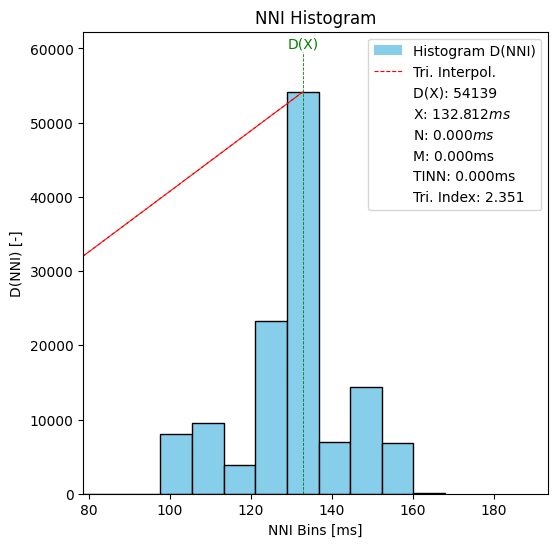

In [ ]:
result_duringGA = data_during.time_domain_analysis(start_GA, channel, duration, threshold)
result_duringGA